# Structuredness of embedding

Some of the structuredness may be due to batch effects - could thus measure structuredness within a batch (here system).

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
import glob
import time

from pynndescent import NNDescent

from sklearn.preprocessing import minmax_scale

from scipy.sparse.csgraph import connected_components
from KDEpy.FFTKDE import FFTKDE

import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
path_data='/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/'
path_ds=path_data+'Blob_examples/'
path_adata=path_data+'retina_adult_organoid/'

## Prepare data
Load data. 
Compute KNN on cell types for downstream analysis.

In [4]:
# Load adatas and precompute KNN
# save times for later analysis
adatas=defaultdict(dict)
knn_times=[]
for ds in sorted(glob.glob(path_ds+'*.h5ad')):
    print(ds)
    kl=float(ds.split('KLW')[1].split('KLCW')[0])
    adata=sc.read(ds)
    for ct in adata.obs.cell_type.unique():
        adata_ct=adata[adata.obs.cell_type==ct,:].copy()
        knn=30
        t1=time.time()
        sc.pp.neighbors(adata_ct, use_rep='X', n_neighbors=knn,key_added='knn'+str(knn))
        t=time.time()-t1
        knn_times.append({'t':t,'knn':knn,'ct':ct,'ds':ds})
        adatas[kl][ct]=adata_ct

/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_eauMr9WK_embed.h5ad
/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_pImntHkr_embed.h5ad
/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_ecXdab0r_embed.h5ad
/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW5.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_f5LroNMT_embed.h5ad


Same as above per system. For now only do for system 1.

In [6]:
adatas_sys1 = defaultdict(dict)
for kl in adatas.keys():
    for ct in adatas[kl].keys():
        knn=30
        adatas_sys1[kl][ct]=adatas[kl][ct][adatas[kl][ct].obs.system=='1',:].copy()
        sc.pp.neighbors(adatas_sys1[kl][ct], use_rep='X', n_neighbors=knn,key_added='knn'+str(knn))

## Embeddings statistics
Look at embedding properties.

Checked only in system 1.

Distn over all cell types

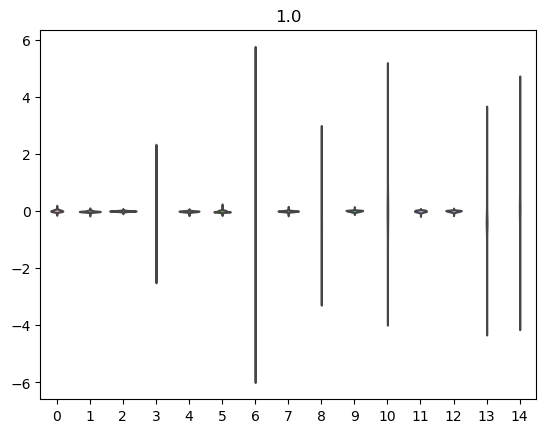

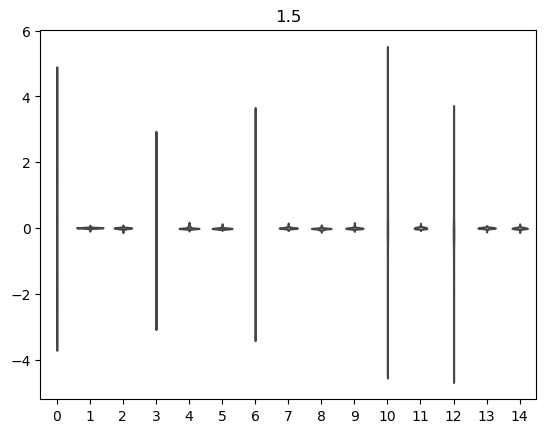

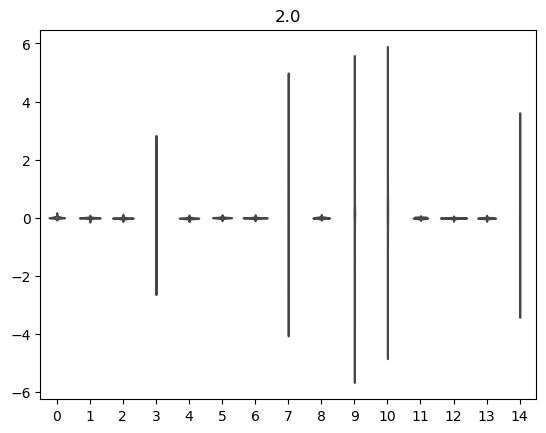

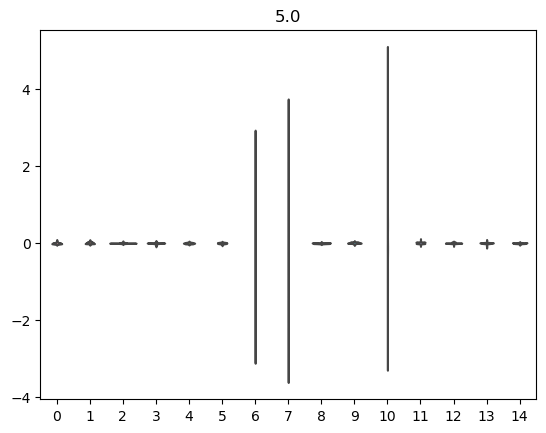

In [74]:
for kl in adatas_sys1.keys():
    vals=[]
    dims=[]
    for ct in adatas_sys1[kl].keys():
        vals.extend(adatas_sys1[kl][ct].X.ravel())
        dims.extend(list(range(adatas_sys1[kl][ct].X.shape[1]))*adatas_sys1[kl][ct].X.shape[0])
    sb.violinplot(x=dims,y=vals,inner=None)
    plt.title(kl)
    plt.show()
    plt.close()

Dim values accross cell types

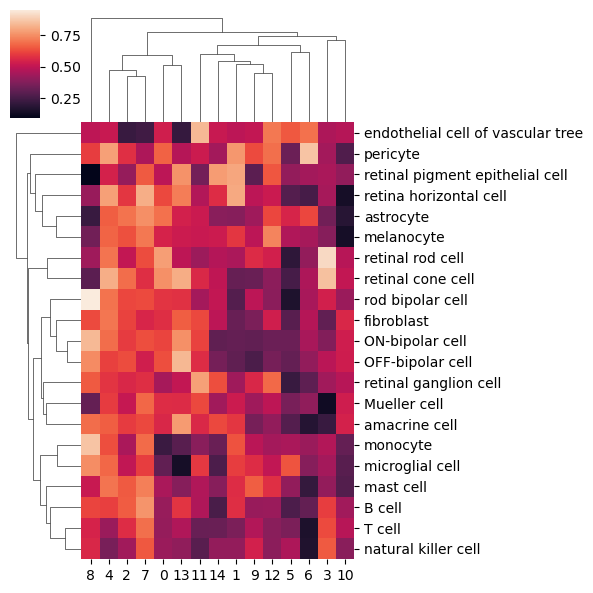

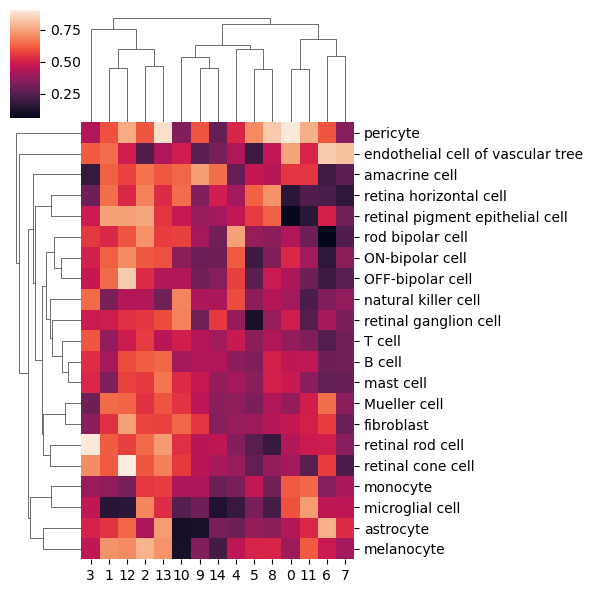

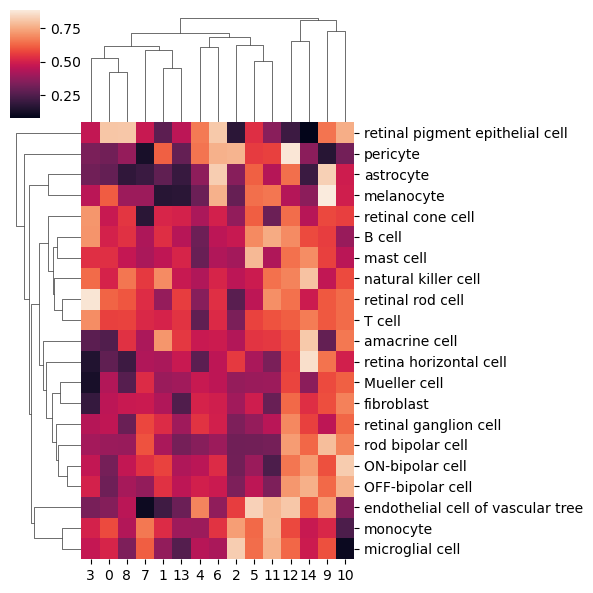

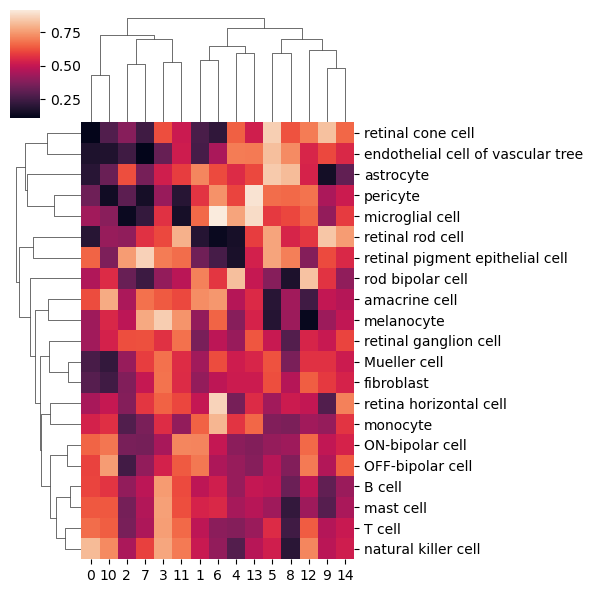

In [119]:
for kl in adatas_sys1.keys():
    vals=[]
    q05=[]
    q95=[]
    for ct in adatas_sys1[kl].keys():
        vals_sub=adatas_sys1[kl][ct].to_df()
        q05.append(vals_sub.quantile(0.05))
        q95.append(vals_sub.quantile(0.95))
        vals.append(pd.Series(vals_sub.mean(axis=0),name=ct))
    vals=pd.concat(vals,axis=1)
    q05=np.array(q05).min(axis=0)
    q95=np.array(q95).max(axis=0)
    vals=pd.DataFrame((vals.T-q05)/(q95-q05),columns=vals.index,index=vals.columns)
    sb.clustermap(vals,figsize=(6,6),yticklabels=True, xticklabels=True)

C: Despite some features having very small range they are still not uniform accross cell types?

C: It is unclear if features with small range are also less meaningful.

UMAP on scaled and not-scaled data (since even small features may be important)

/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_eauMr9WK_embed.h5ad


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


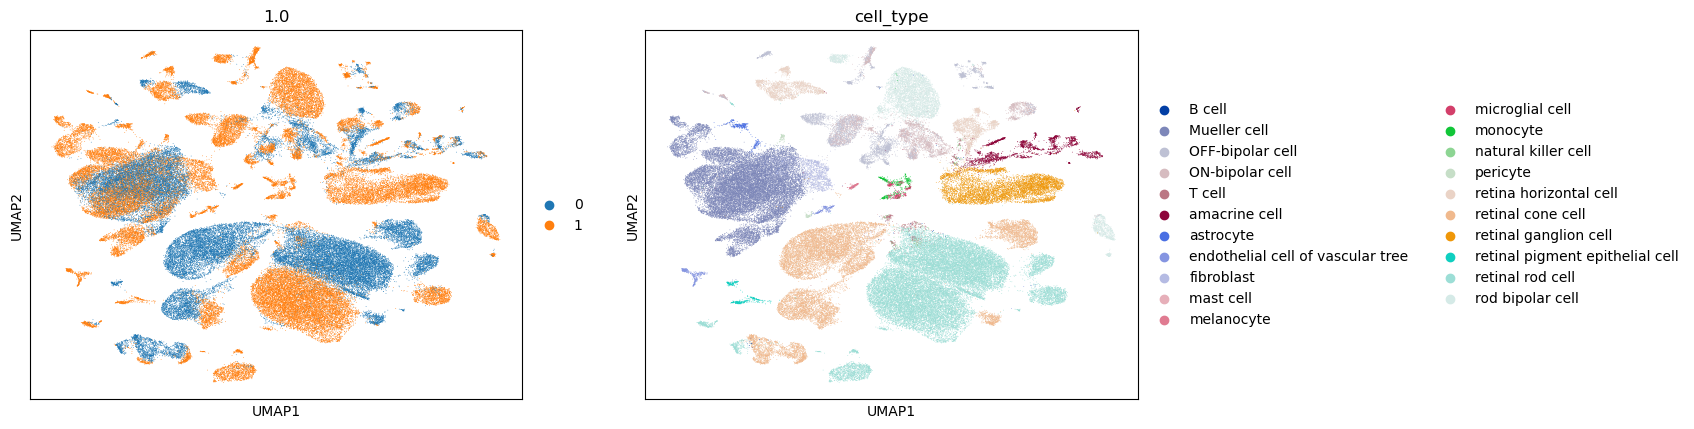

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


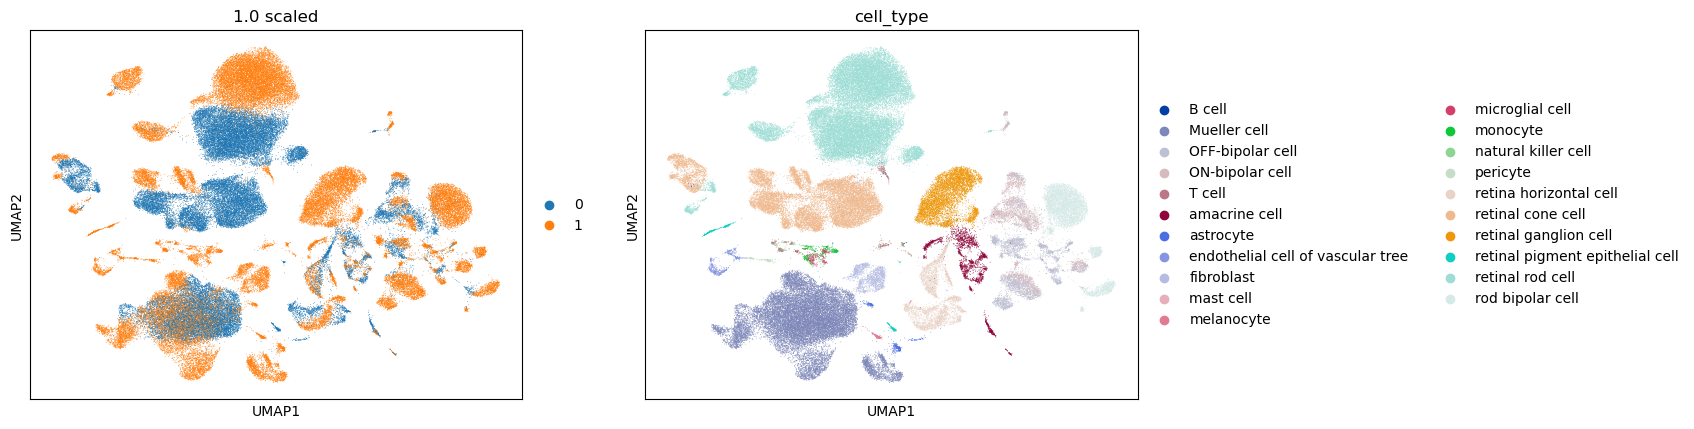

/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_pImntHkr_embed.h5ad


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


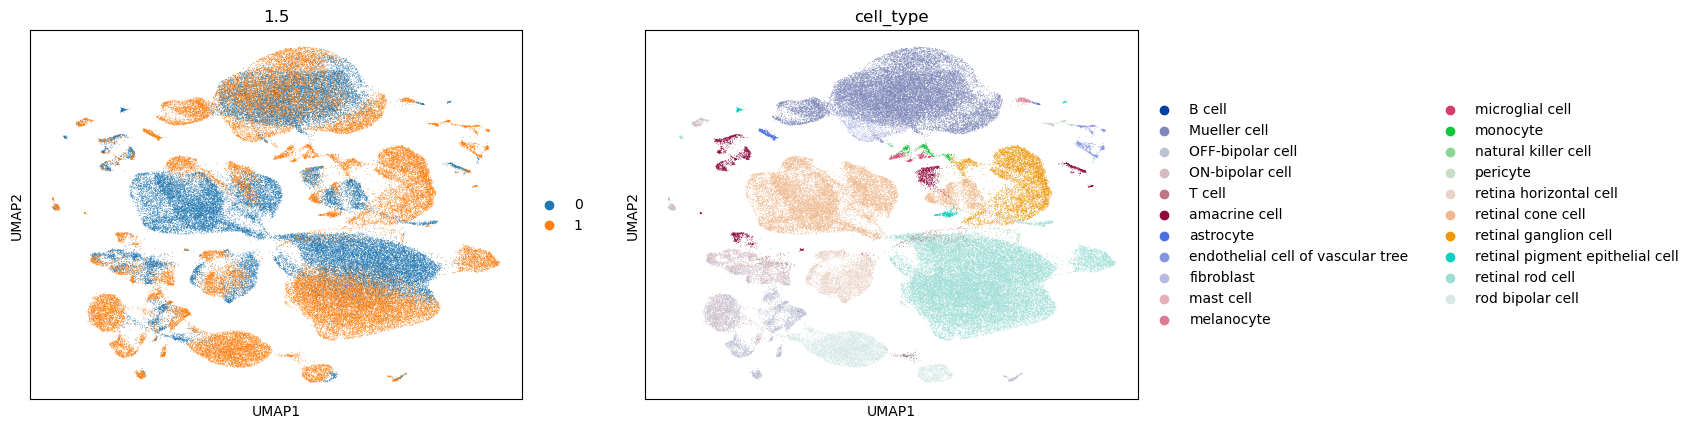

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


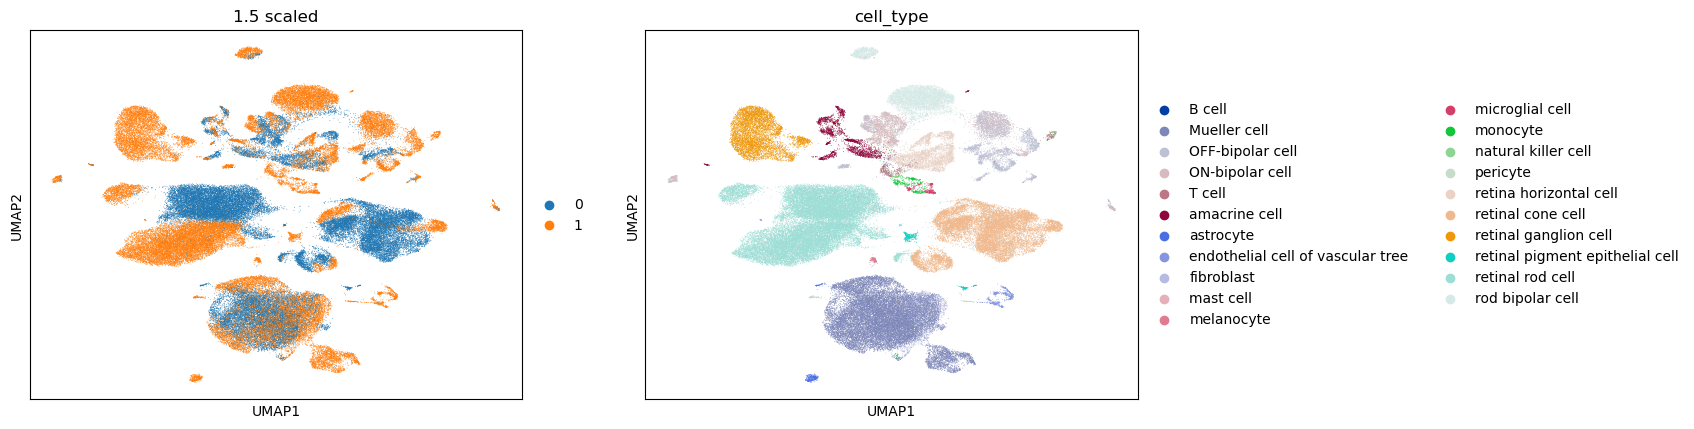

/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_ecXdab0r_embed.h5ad


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


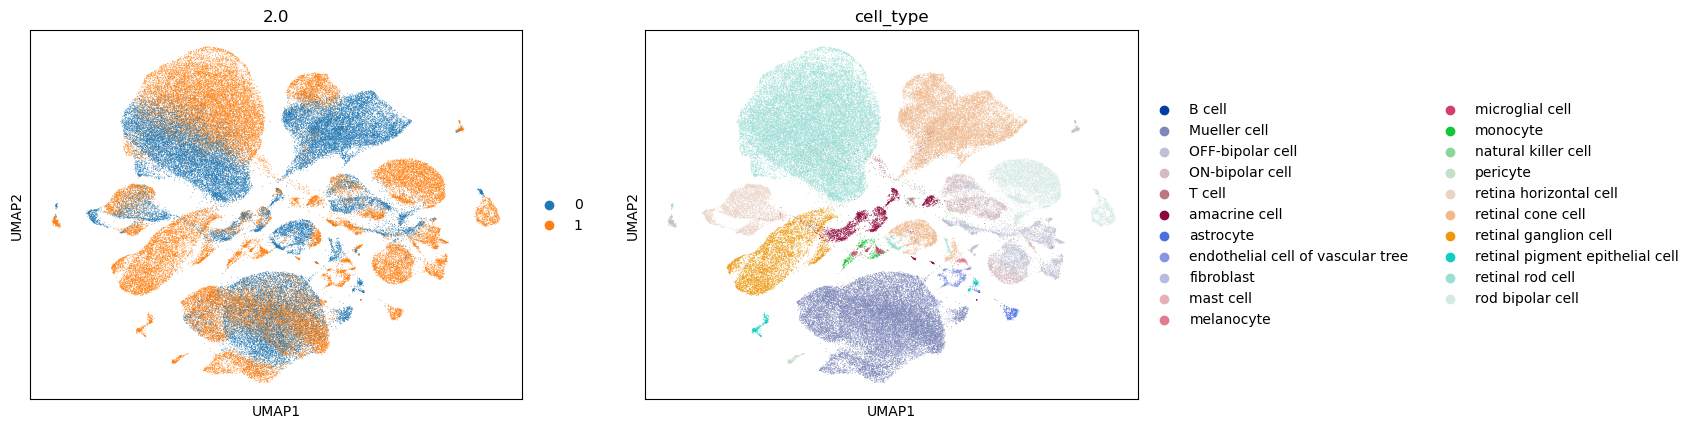

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


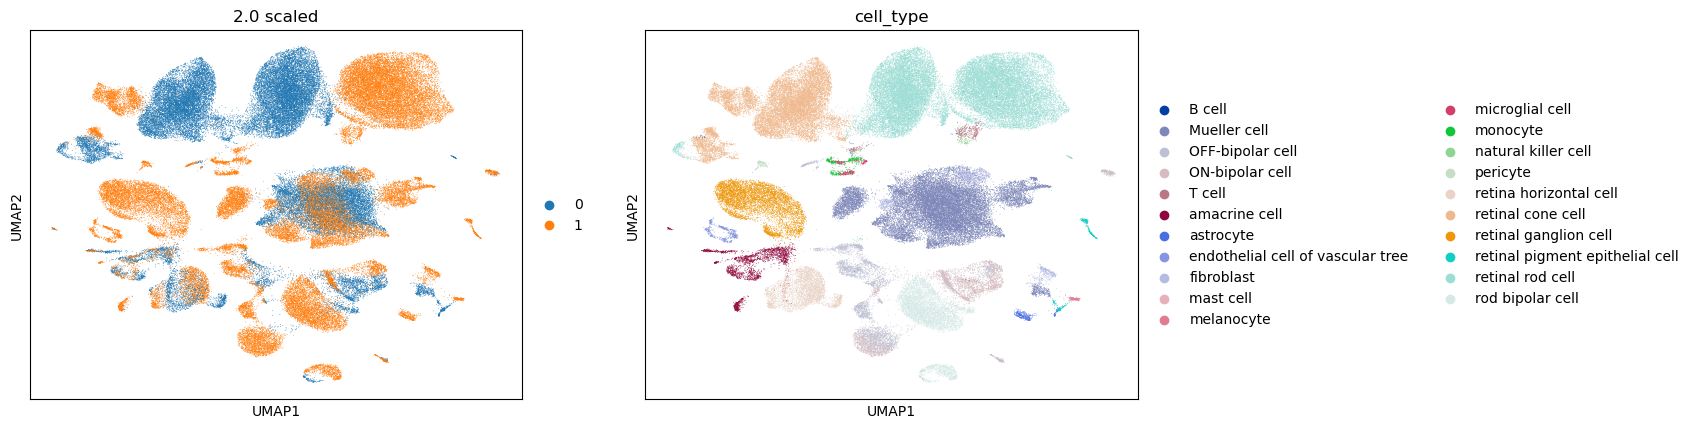

/net/bmc-lab6/data/lab/kellis/users/khrovati/data/cross_system_integration/Blob_examples/MANoneSDFalseOVMfeatureKLW5.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_f5LroNMT_embed.h5ad


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


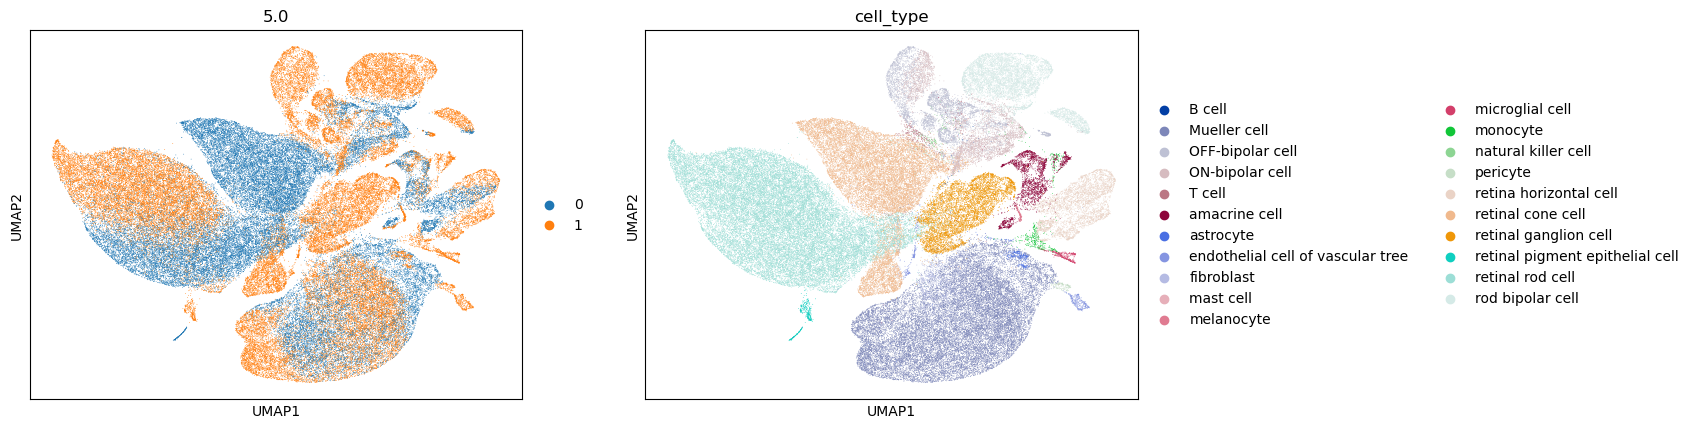

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


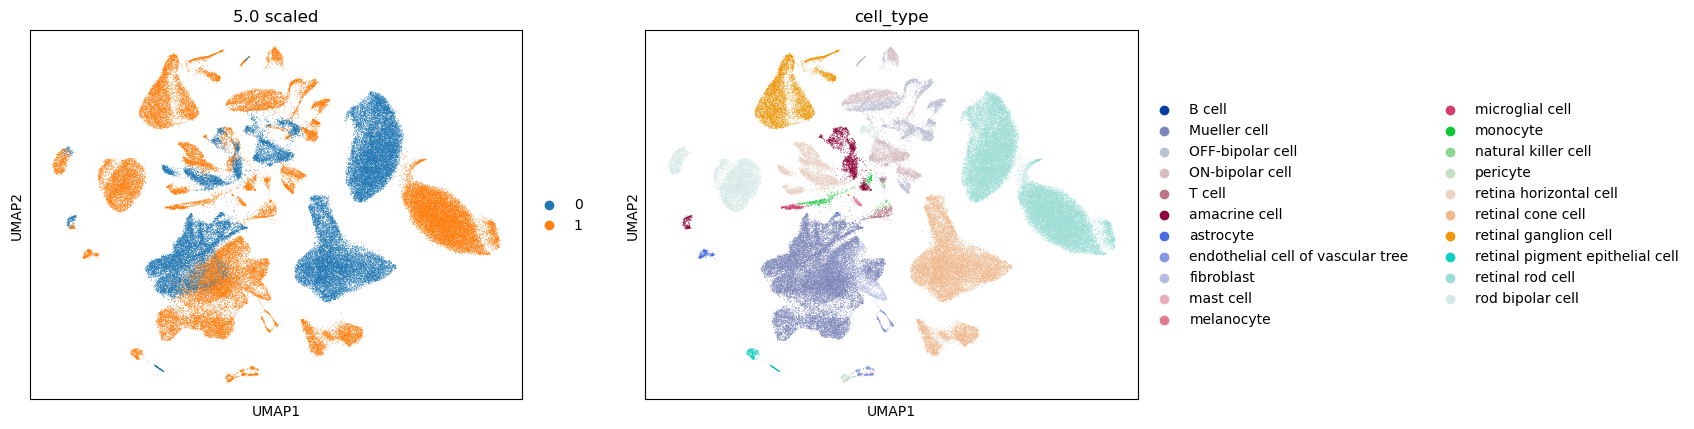

In [121]:
# Load adatas and precompute KNN
# save times for later analysis
for ds in sorted(glob.glob(path_ds+'*.h5ad')):
    print(ds)
    kl=float(ds.split('KLW')[1].split('KLCW')[0])
    adata=sc.read(ds)
    sc.pp.neighbors(adata, use_rep='X', n_neighbors=30)
    sc.tl.umap(adata)
    sc.pl.umap(adata,color=['system','cell_type'],title=str(kl))
    sc.pp.scale(adata)
    sc.pp.neighbors(adata, use_rep='X', n_neighbors=30)
    sc.tl.umap(adata)
    sc.pl.umap(adata,color=['system','cell_type'],title=str(kl)+' scaled')

C: It seems that scaling the data reduces noise but it may also increaase batch effects?

What happens if we do the embedding on only the 3 large features vs only the 12 small features. I.e. Are the 12 small features capturing bio and batch info?

0     0.016769
1     0.018295
2     0.009370
3     0.013969
4     0.013208
5     0.016398
6     1.021222
7     0.914686
8     0.009322
9     0.014825
10    0.831532
11    0.017602
12    0.012172
13    0.016851
14    0.009810
dtype: float32

Large feats ['6', '7', '10']
Small feats ['0', '1', '2', '3', '4', '5', '8', '9', '11', '12', '13', '14']


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


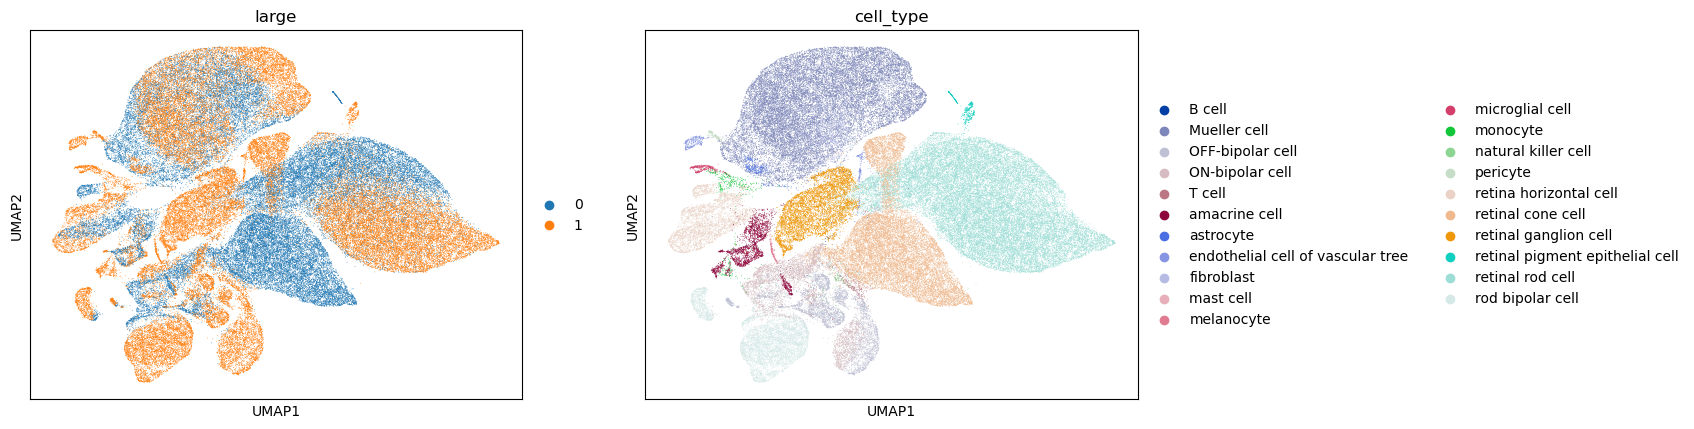

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


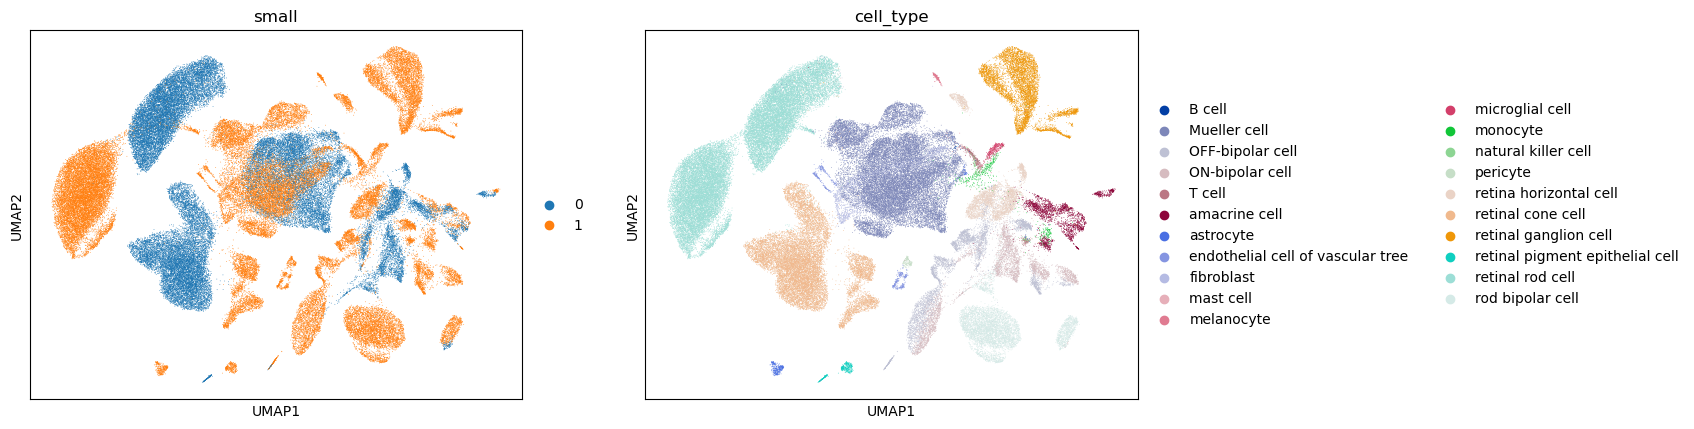

In [143]:
#adata=sc.read(path_ds+'MANoneSDFalseOVMfeatureKLW5.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_f5LroNMT_embed.h5ad')
#feat_stds=adata.to_df().std()
display(feat_stds)
thr=0.5
feats_large=list(feat_stds.index[feat_stds>=thr])
print('Large feats',feats_large)
feats_small=list(feat_stds.index[feat_stds<thr])
print('Small feats',feats_small)
for feat_type,feats in [('large',feats_large),('small',feats_small)]:
    adata_sub=adata[:,feats].copy()
    sc.pp.neighbors(adata_sub, use_rep='X', n_neighbors=30)
    sc.tl.umap(adata_sub)
    sc.pl.umap(adata_sub,color=['system','cell_type'],title=feat_type)
del adata_sub

C: It seems that the small features do capture bio variation, but because they are small our NN computation approach removes a lot of this biological variation.

## Moran's I

One option would be to use Moran's I. It could be computed on the same set of genes across datasets.

In [3]:
adata_int=sc.read(path_adata+'combined_HVG.h5ad')

In [308]:
data=[]
for ct in adata_int.obs.cell_type.unique():
    print(ct)
    sys=1
    adata_sub=adata_int[
        (adata_int.obs.system==sys).values&\
        (adata_int.obs.cell_type==ct).values,:].copy()
    # Remove lowly expr genes before HVG computation - more likely to be bio relevant
    # and non-low expr noise variable genes
    sc.pp.filter_genes(adata_sub, min_cells=adata_sub.shape[0]*0.1) 
    hvgs=sc.pp.highly_variable_genes(
        adata_sub,n_top_genes=100, 
        # problematic as some samples little cells per ct
        # Otherwise may be good to use batch to reduce sample batch effects
        #batch_key='sample_id',
        inplace=False
    ).query('highly_variable==True').index
    for kl in adatas_sys1.keys():
        morans_i=sc.metrics._morans_i._morans_i(
            g=adatas_sys1[kl][ct].obsp['knn30_connectivities'],
            vals=adata_sub[adatas_sys1[kl][ct].obs_names,hvgs].X.T)
        data.append({'kl':kl,'ct':ct,'i':morans_i.mean()})
data=pd.DataFrame(data)

melanocyte
retinal pigment epithelial cell
microglial cell
T cell
retinal rod cell
retinal cone cell
retina horizontal cell
OFF-bipolar cell
rod bipolar cell
ON-bipolar cell
amacrine cell
retinal ganglion cell
Mueller cell
astrocyte
pericyte
endothelial cell of vascular tree
monocyte
natural killer cell
mast cell
fibroblast
B cell


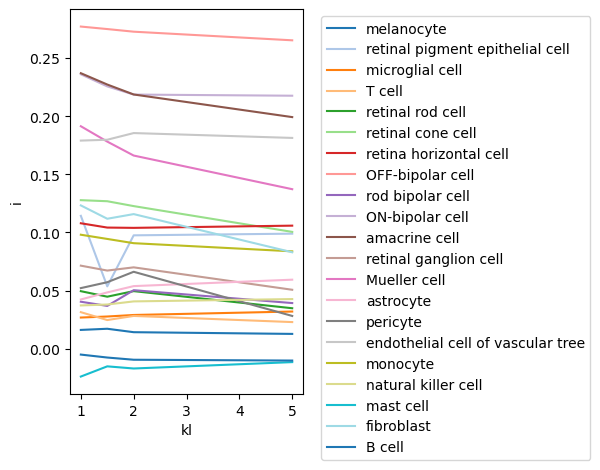

In [360]:
# Plot MI over cts
rcParams['figure.figsize']=(3,5)
sb.lineplot(x='kl',y='i',hue='ct',data=data,palette='tab20')
plt.legend(bbox_to_anchor=(1.05,1))

C: Some cell types have much lover overall Moran's I. - check what could be the reason (e.g. lack of bio var in general due to low cell N, ....)

In [331]:
# N cells
adata_int.obs.cell_type.value_counts()

retinal rod cell                     28836
Mueller cell                         22635
retinal cone cell                    15550
retinal ganglion cell                 6121
rod bipolar cell                      5668
OFF-bipolar cell                      4612
ON-bipolar cell                       3802
retina horizontal cell                3643
amacrine cell                         2373
fibroblast                            1607
endothelial cell of vascular tree      576
T cell                                 459
monocyte                               437
retinal pigment epithelial cell        400
astrocyte                              376
microglial cell                        343
natural killer cell                    174
pericyte                               160
melanocyte                             157
B cell                                  37
mast cell                               30
Name: cell_type, dtype: int64

In [334]:
# Add N cells to data
data['log_n_cells']=np.log(data.ct.map(adata_int.obs.cell_type.value_counts().to_dict()))

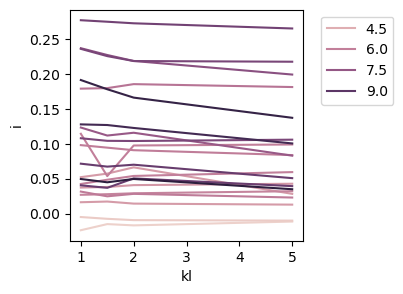

In [356]:
# # Plot MI over cts colored by N cells
rcParams['figure.figsize']=(3,3)
sb.lineplot(x='kl',y='i',hue='log_n_cells',data=data)
plt.legend(bbox_to_anchor=(1.05,1))

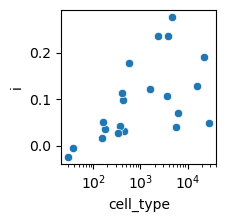

In [355]:
# N cells vs moran's I
rcParams['figure.figsize']=(2,2)
sb.scatterplot(x=adata_int.obs.cell_type.value_counts(),y=data.query('kl==1').set_index('ct')['i'])
plt.xscale('log')

C: There is some correlation between N cells and Morns'I.

In [345]:
data.query('kl==1').set_index('ct')[['i','log_n_cells']].sort_values('i')

i  log_n_cells
ct                                                      
mast cell                         -0.023940     3.401197
B cell                            -0.005045     3.610918
melanocyte                         0.016161     5.056246
microglial cell                    0.026813     5.837730
T cell                             0.031428     6.129050
natural killer cell                0.037208     5.159055
rod bipolar cell                   0.040404     8.642592
astrocyte                          0.042324     5.929589
retinal rod cell                   0.049473    10.269380
pericyte                           0.052117     5.075174
retinal ganglion cell              0.071420     8.719481
monocyte                           0.098016     6.079933
retina horizontal cell             0.107869     8.200563
retinal pigment epithelial cell    0.114259     5.991465
fibroblast                         0.123221     7.382124
retinal cone cell                  0.127744     9.651816
endothelial cell of vascular tree  0.178965     6.356108
Mueller cell                       0.191306    10.027253
ON-bipolar cell                    0.235977     8.243283
amacrine cell                      0.236917     7.771910
OFF-bipolar cell                   0.277027     8.436417

Computing avg Moran's I on cell types with many cells. This will less prioritise cell types with lower overall moransi values - should this maybe be scaled in some way? But hard to do befor comparing accross datasets - can scale per ct only when looking accross runs.

/tmp/ipykernel_208856/1551718873.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sb.lineplot(x='kl',y='i',data=data.query('log_n_cells>=@thr').groupby('kl').mean())


<Axes: xlabel='kl', ylabel='i'>

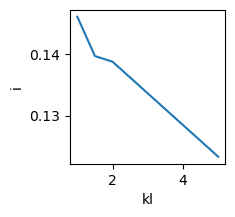

In [354]:
# Avg morans I when using only cts with many cells
rcParams['figure.figsize']=(2,2)
thr=np.log(1000)
sb.lineplot(x='kl',y='i',data=data.query('log_n_cells>=@thr').groupby('kl').mean())

### How Moran's I relative value should be computed
Simulate less/more structured data (by using more/less standardised latent components) and then compute relative moran's I as ratio or difference and see hos are the values affected by different original Moran's I-s (e.g. for less/more variable genes).

In [63]:
# Compute morna's I on one sample-ct group with different bio info (different N features)
data=[]
ct='Mueller cell'
sys=1
sample='R-00646_01_LEFT_peripheral_neural_CS'
adata_sub=adatas_sys1[1][ct]
adata_sub=adata_sub[adata_sub.obs.sample_id==sample,:].copy()
adata_sub_expr=adata_int[
    (adata_int.obs.sample_id==sample).values&\
    (adata_int.obs.system==sys).values&\
    (adata_int.obs.cell_type==ct).values,:].copy()
# Remove lowly expr genes before HVG computation - more likely to be bio relevant
# and non-low expr noise variable genes
sc.pp.filter_genes(adata_sub_expr, min_cells=adata_sub.shape[0]*0.1) 
expr=adata_sub_expr[adata_sub.obs_names,].X.T
sc.pp.scale(adata_sub)
for n in np.array(range(1,6))*3:
    print(n)
    adata_sub2=adata_sub[:,:n]
    sc.pp.neighbors(adata_sub2, use_rep='X')
    morans_i=sc.metrics._morans_i._morans_i(g=adata_sub2.obsp['connectivities'], vals=expr)
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_sub_expr.var_names)
    morans_i['n_features']=n
    data.append(morans_i)
data=pd.concat(data)

3
6
9
12
15


In [64]:
# Scale morans i 0-1
data['morans_i_scl']=(data['morans_i']+1)/2

In [65]:
# Compute differences between full feature (n=15) and reduced features (n<15)
# relative (/) or absolute (-) diff 
data_full=data.query('n_features==15')
diffs=[]
for n in np.array(range(1,5))*3:
    data_sub=data.query('n_features==@n')
    diff_abs=pd.DataFrame((data_sub.morans_i_scl-data_full.morans_i_scl).rename('diff'))
    diff_abs['type']='abs'
    diff_rel=pd.DataFrame((data_sub.morans_i_scl/data_full.morans_i_scl).rename('diff'))
    diff_rel['type']='rel'
    diff=pd.concat([diff_abs,diff_rel])
    diff['n']=n
    diff['i_original']=data_full.morans_i_scl
    diffs.append(diff)
diffs=pd.concat(diffs)  

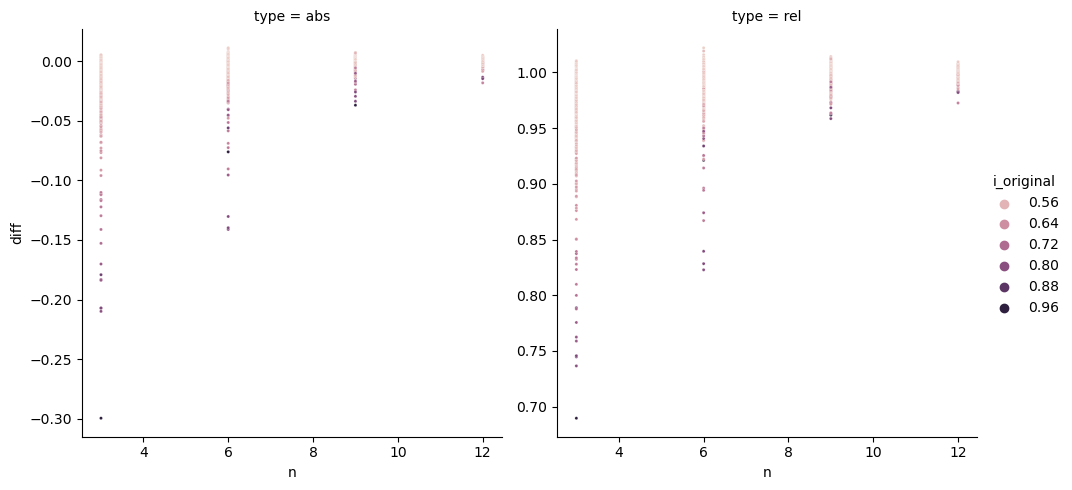

In [66]:
# I difference change colored by original I
sb.relplot(x='n',y='diff',hue='i_original',col='type',data=diffs,s=5,
           facet_kws={'sharey': False})

In [67]:
# Bin original I to make easier to plot
diffs['bin']=pd.cut(diffs['i_original'],10).apply(lambda x: str(x.left)+'-'+str(x.right))

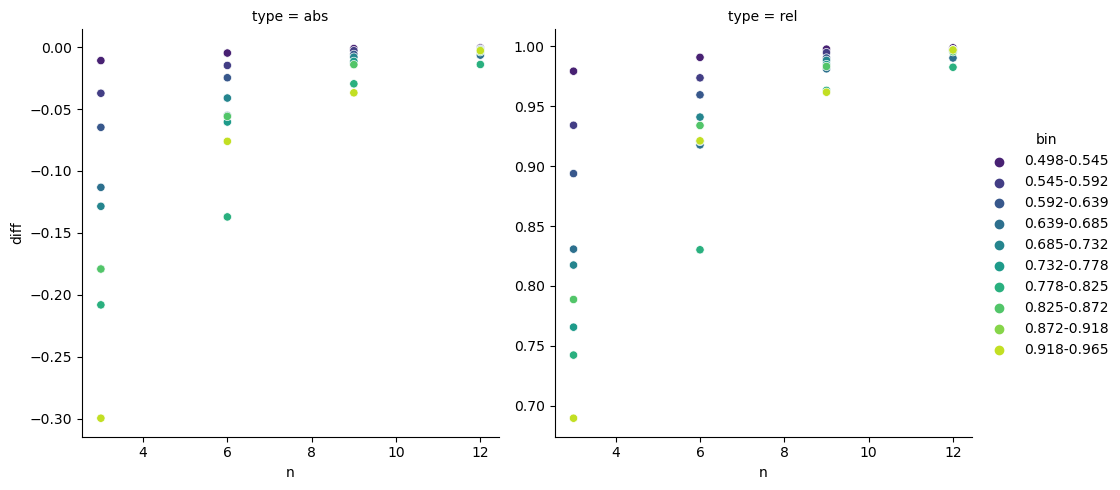

In [68]:
# I difference change accross original I bins
sb.relplot(x='n',y='diff',hue='bin',col='type',
    data=diffs.groupby(['bin','n','type'],observed=True)['diff'].mean().reset_index(),
          facet_kws={'sharey': False},palette='viridis')

C: It seems that genes that are more variable from the start end up changing more anyways, regardless of how difference is computed (abs or relative). Thus retaining more genes (lower I) may not be that important as anyways they will be overshadowed by more changing genes the way the scaling can be done.

C: This is computed on all genes rather than just HVGs (present in the integration data). The results there may be a bit different, but in general it seems that also genes with low Moran's I (which may be more common in the HVG data) capture the loss of bio preservation.

## Hopkin's clustering statistic

The KNN computation of scanpy does not save which are 30 top neighboirs (can assume based on non-0 values but may be some KNNs could be 0 in extreme cases) and also includes self.

In [229]:
def hopkins(data,n_points=100,seed=0):
    """
    Compute hopkins statistic
    """
    index = NNDescent(data,metric='euclidean',random_state=seed,n_jobs=-1)
    index.prepare()
    rng = np.random.default_rng(seed)
    # Sample with replacement only if we dont have enough data points
    replace=n_points>data.shape[0]
    samples=rng.choice(range(data.shape[0]), size=n_points, replace=replace)
    d_samples=index.query(data[samples,:],k=2)[1][:,1].sum()
    random=rng.uniform(low=data.min(axis=0),high=data.max(axis=0),size=(n_points,data.shape[1]))
    d_random=index.query(random,k=2)[1][:,1].sum()
    h=d_random/(d_random+d_samples)
    return h

In [247]:
# Hopkins statistic per cell type and kl
data=[]
for kl in adatas_sys1.keys():
    print(kl)
    for ct in adatas_sys1[kl].keys():
        data.append({'kl':kl,'ct':ct,'h':hopkins(adatas_sys1[kl][ct].X)})
data=pd.DataFrame(data)

1.0
1.5
2.0
5.0


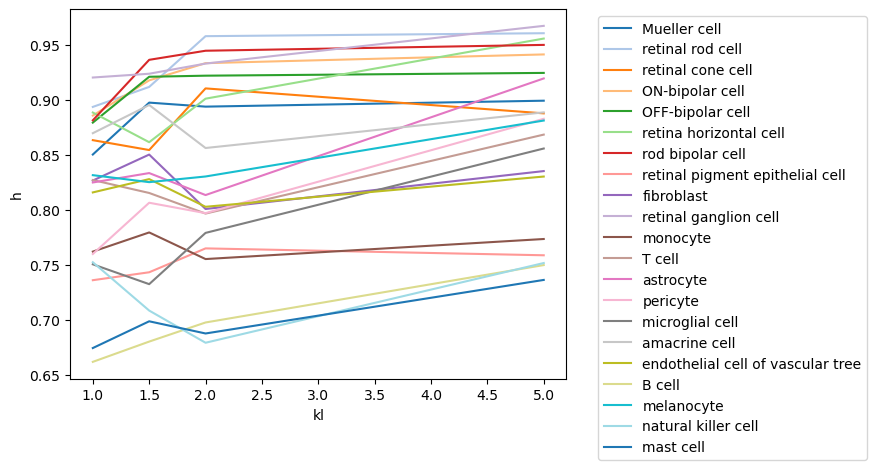

In [251]:
# Plot hopkins statistics
sb.lineplot(x='kl',y='h',hue='ct',data=data,palette='tab20')
plt.legend(bbox_to_anchor=(1.05,1))

C: Hopkins statistic does not give the expected trend. If anything it may be reverse. Not even for cts where the difference should be obvious (retinal rod cell, retinal cone cell, etc.).

## Analyse KNN distances
Probably need to consider that distances will be affected by embedding properties (N components & their sizes) - may thus need to normalise somehow. 

Distn of mean distance to 30 KNNs

kl 1, mean 0.393, var 0.022, 1st_quantile 0.214, std/mean 0.377, std/1st_quantile 0.693
kl 2, mean 0.304, var 0.012, 1st_quantile 0.174, std/mean 0.362, std/1st_quantile 0.632
kl 2, mean 0.232, var 0.013, 1st_quantile 0.125, std/mean 0.486, std/1st_quantile 0.899
kl 5, mean 0.059, var 0.001, 1st_quantile 0.028, std/mean 0.571, std/1st_quantile 1.184


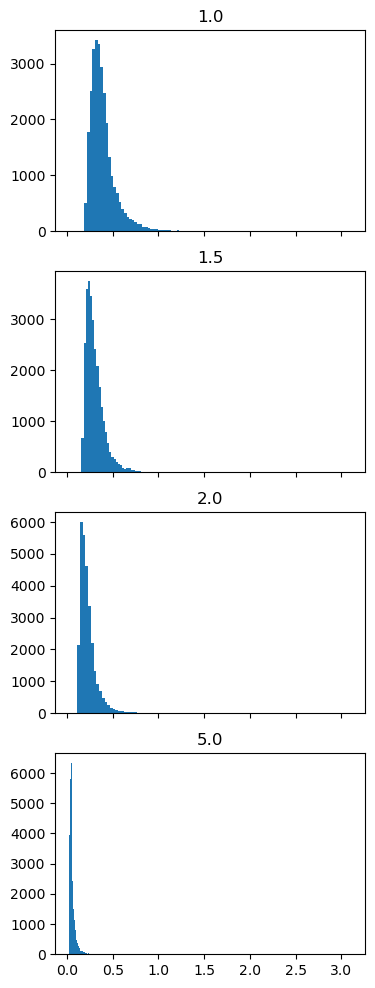

In [52]:
ct='retinal rod cell'
fig,axs=plt.subplots(len(adatas),1,figsize=(4,3*len(adatas)),sharex=True)
for ax,kl in zip(axs,adatas.keys()):
    mean_distances=pd.DataFrame({'rows':adatas[kl][ct].obsp['knn30_distances'].indices,
           'distances':adatas[kl][ct].obsp['knn30_distances'].data}).groupby('rows')['distances'].mean()
    ax.hist(mean_distances,bins=100)
    ax.set_title(kl)
    print('kl %1.f, mean %.3f, var %.3f, 1st_quantile %.3f, std/mean %.3f, std/1st_quantile %.3f'%(
        kl,mean_distances.mean(),mean_distances.var(), mean_distances.quantile(0.01),
        mean_distances.std()/mean_distances.mean(),
        mean_distances.std()/mean_distances.quantile(0.01)))

Compute mean/var etc of means of per cell KNN distances. 

KNN distance shows some differences, but it may be just due to cluster tightness and not clustering. Need to test more in detail. For example, mean and 1st 1st qunatile of means are smaller when increasing kl - probably because points are pushed to N(0,1) so they in general have lower distances, which also affects var/std.

std_of_means/mean_of_means normalisation is not ok as it is affected by the distn being skewed anyways if there is more non-uniformity. - Would need to compare to smallest cell KNN means (low quantile of KNN means) or sth like that. - But that also does not give the expected result - the scaling is not ok.

## Connected components

In [43]:
for kl in adatas.keys():
    for ct in sorted(adatas[kl].keys()):
        n_comp=connected_components(adatas[kl][ct].obsp['knn30_connectivities'],directed=False)[0]
        print('kl',kl,'ct',ct,'n_comp',n_comp)
                                                                                

kl 1.0 ct B cell n_comp 1
kl 1.0 ct Mueller cell n_comp 1
kl 1.0 ct OFF-bipolar cell n_comp 1
kl 1.0 ct ON-bipolar cell n_comp 1
kl 1.0 ct T cell n_comp 1
kl 1.0 ct amacrine cell n_comp 1
kl 1.0 ct astrocyte n_comp 1
kl 1.0 ct endothelial cell of vascular tree n_comp 1
kl 1.0 ct fibroblast n_comp 1
kl 1.0 ct mast cell n_comp 1
kl 1.0 ct melanocyte n_comp 1
kl 1.0 ct microglial cell n_comp 1
kl 1.0 ct monocyte n_comp 1
kl 1.0 ct natural killer cell n_comp 1
kl 1.0 ct pericyte n_comp 1
kl 1.0 ct retina horizontal cell n_comp 1
kl 1.0 ct retinal cone cell n_comp 1
kl 1.0 ct retinal ganglion cell n_comp 1
kl 1.0 ct retinal pigment epithelial cell n_comp 1
kl 1.0 ct retinal rod cell n_comp 1
kl 1.0 ct rod bipolar cell n_comp 1
kl 1.5 ct B cell n_comp 1
kl 1.5 ct Mueller cell n_comp 1
kl 1.5 ct OFF-bipolar cell n_comp 1
kl 1.5 ct ON-bipolar cell n_comp 1
kl 1.5 ct T cell n_comp 1
kl 1.5 ct amacrine cell n_comp 1
kl 1.5 ct astrocyte n_comp 1
kl 1.5 ct endothelial cell of vascular tree n_comp 

Connected components is not meaningful as mainly 1 component.

## KDE distn

Availiable kernels and bandwidth determination methods

In [46]:
# Availiable kernels
FFTKDE._available_kernels.keys() 

dict_keys(['gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight', 'triweight', 'tricube', 'cosine'])

In [57]:
# Availiable width selection method
FFTKDE._bw_methods.keys()

dict_keys(['silverman', 'scott', 'ISJ'])

Work on embedding space from model

In [19]:
# Optimal bw for every dimension
for i in range(adatas[1.0]['retinal rod cell'].shape[1]):
    print(FFTKDE(kernel='cosine', bw='ISJ').fit(adatas[1.0]['retinal rod cell'].X[:,i]).bw)

0.00010867124534071339
4.0542854411107124e-05
2.022360645344203e-05
0.005653507473887762
3.224628755179354e-05
6.0667192088831834e-05
0.03856841783277366
5.68852763249062e-05
0.02044939926455194
3.487876616787538e-05
0.029157984530043327
9.92628577142253e-05
4.730165652589785e-05
0.009126606126663085
0.016076475609664166


C: Optimal BW is very variable accross dimensions of the embedding

In [22]:
# Try to set single BW accross dims
grid, density = FFTKDE(kernel='cosine', bw=0.01).fit(adatas[1.0]['retinal rod cell'].X).evaluate()

AssertionError: 

C: Can not just set one bw accross dims, both due to worse performance as well as some dimensions not even having enough of a span to accomodate high BW

Try to work with PCA - maybe we can use top 2 dims and may have more similar BW

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:563: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _ = pl.figure(


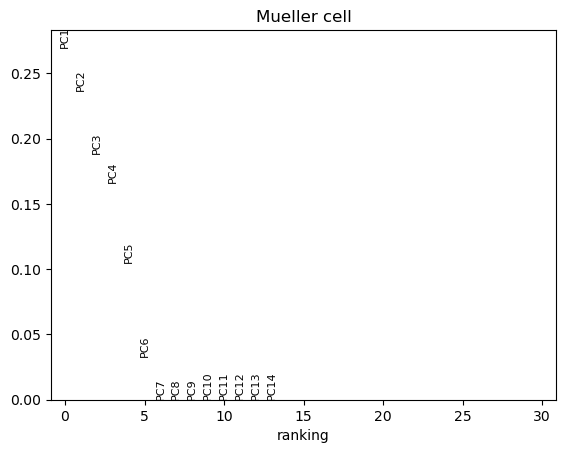

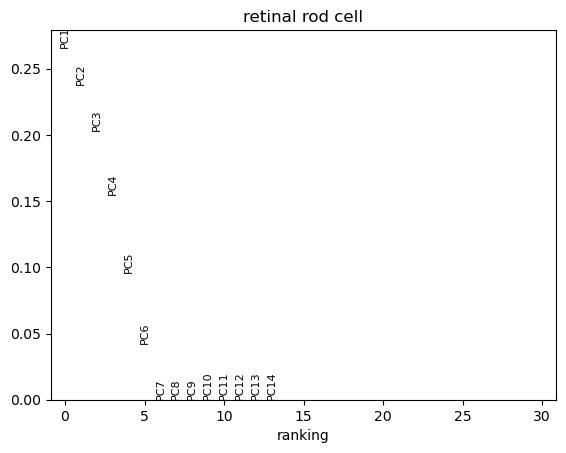

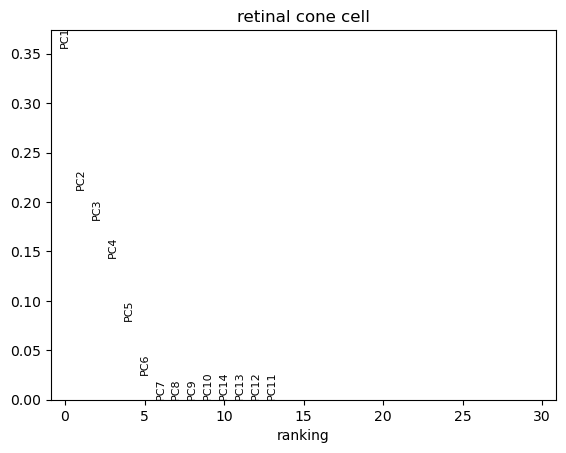

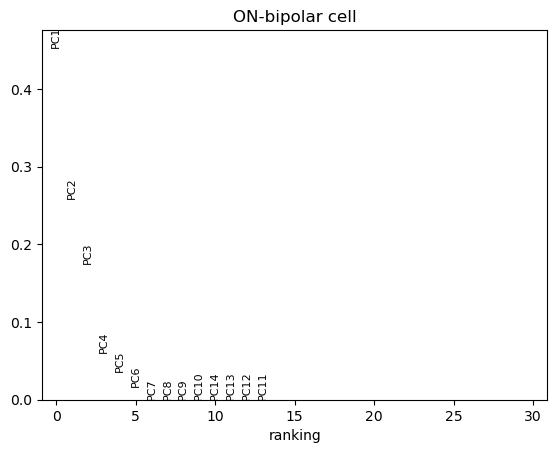

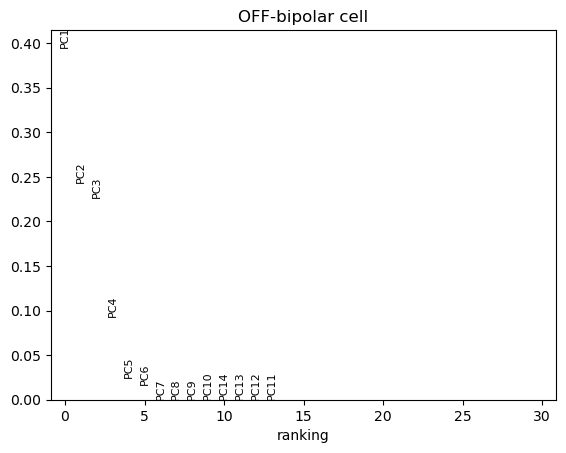

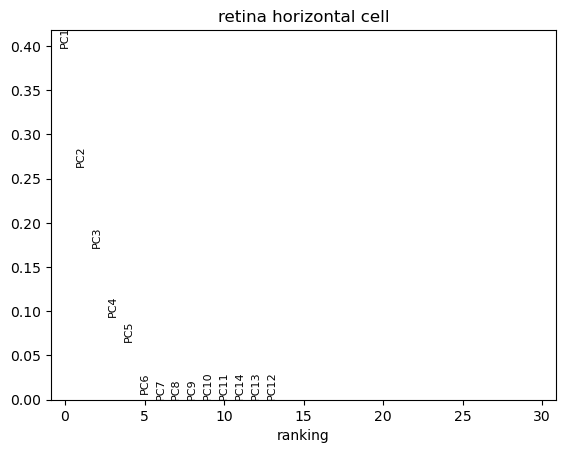

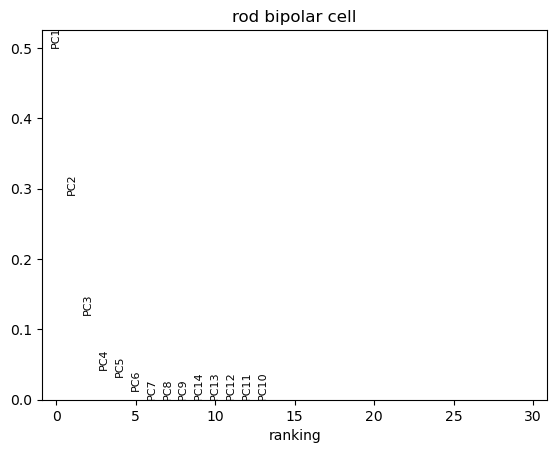

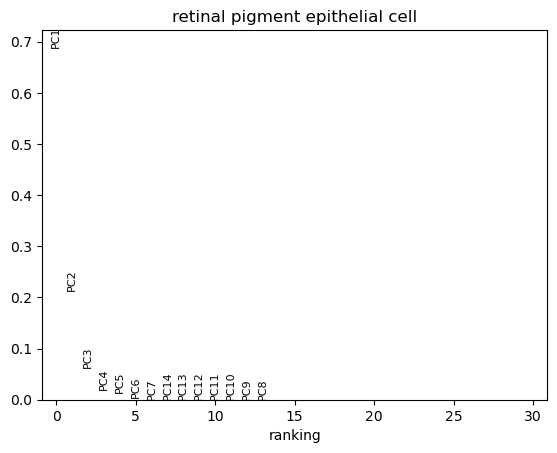

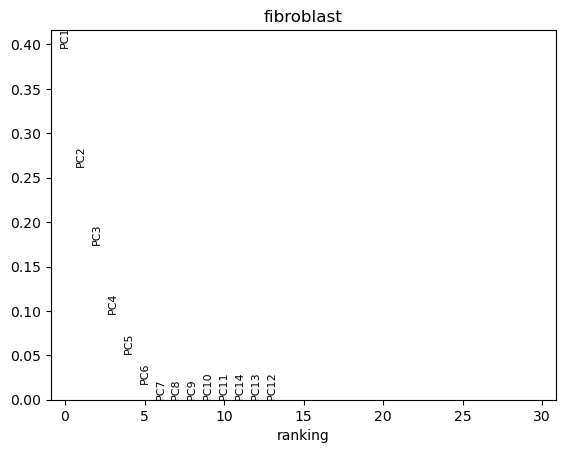

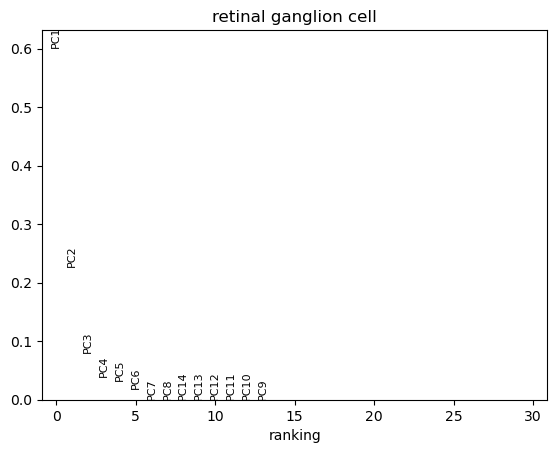

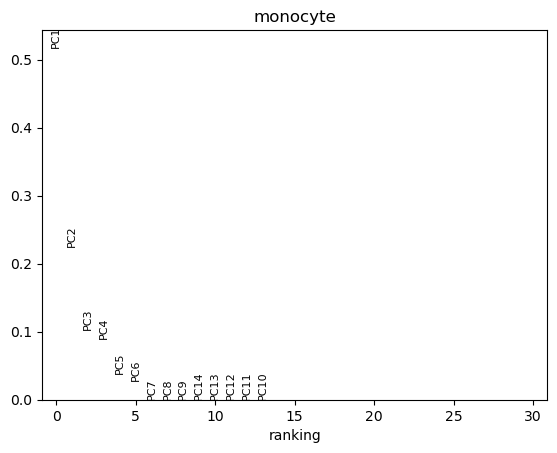

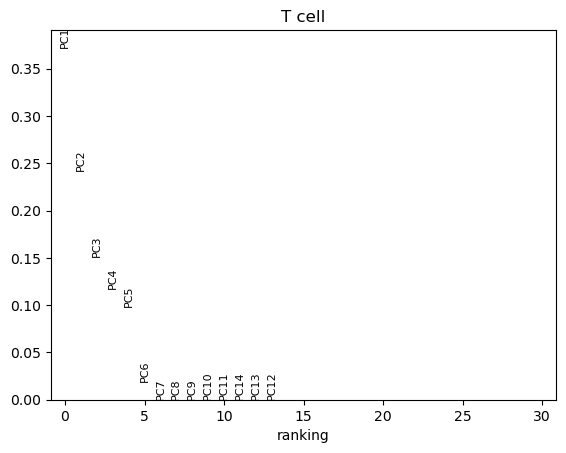

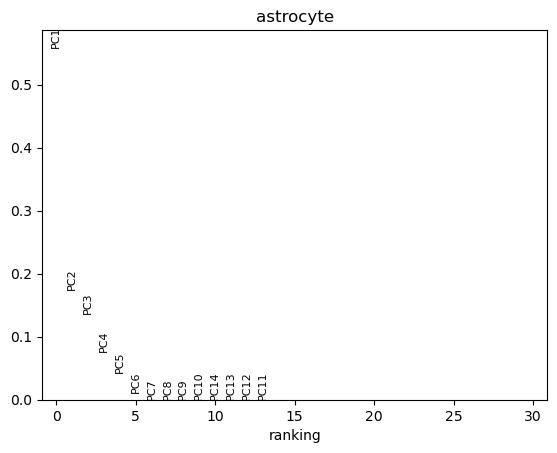

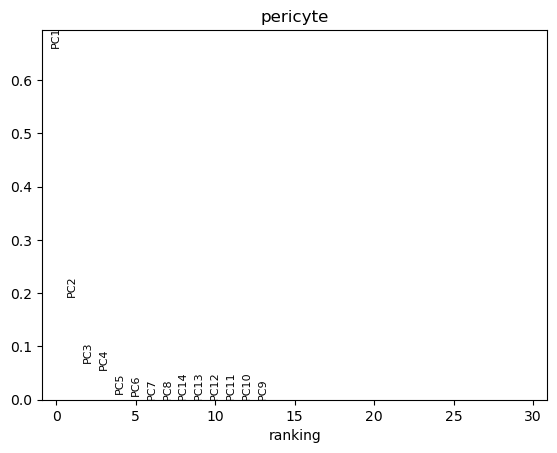

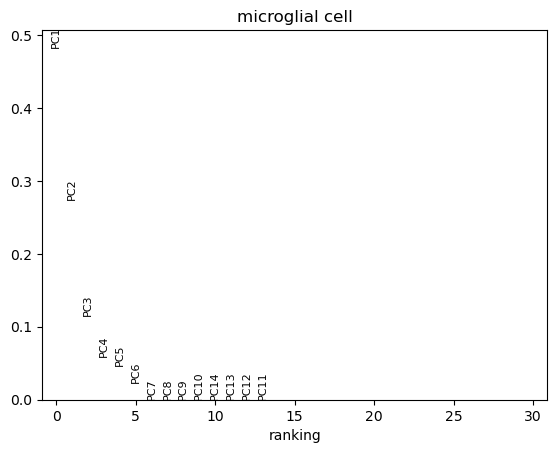

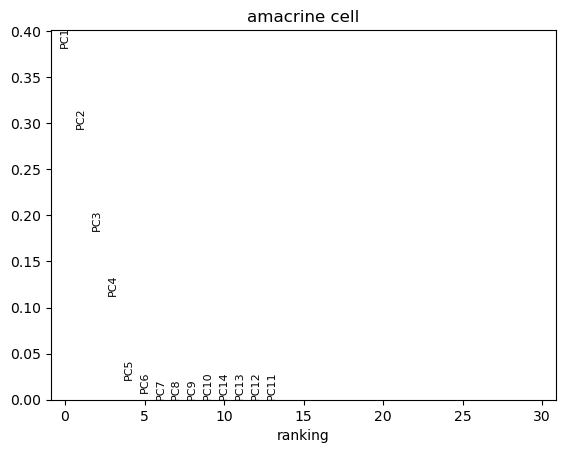

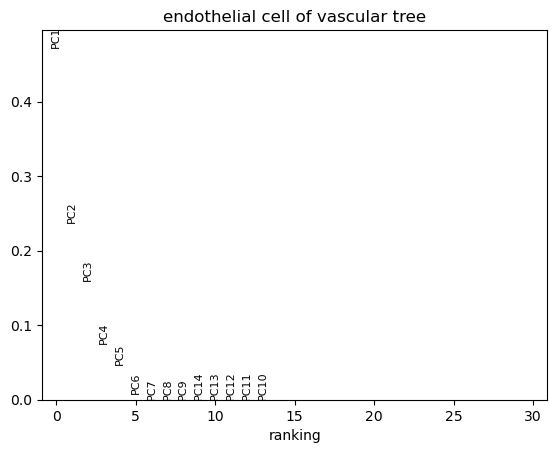

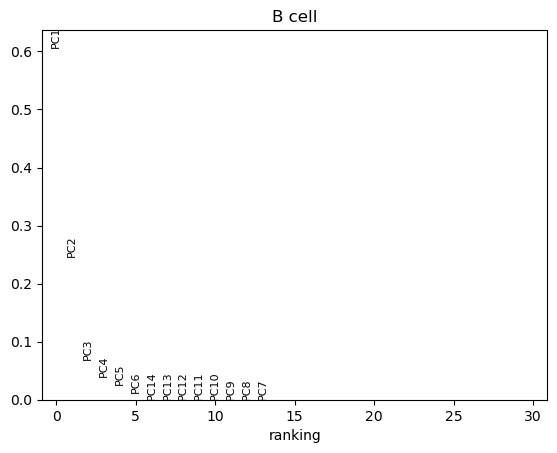

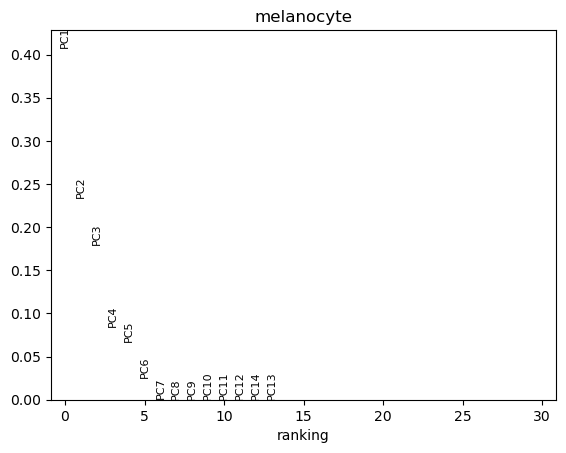

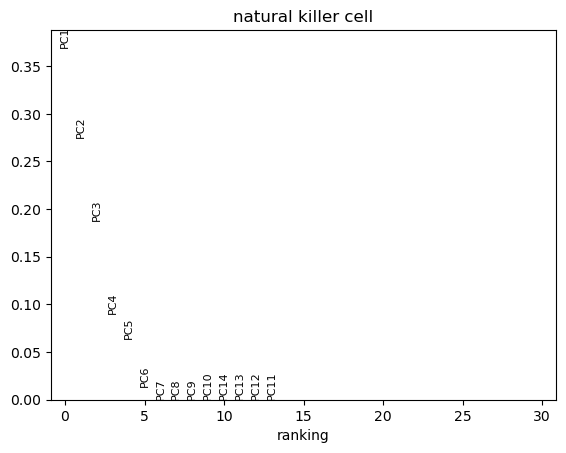

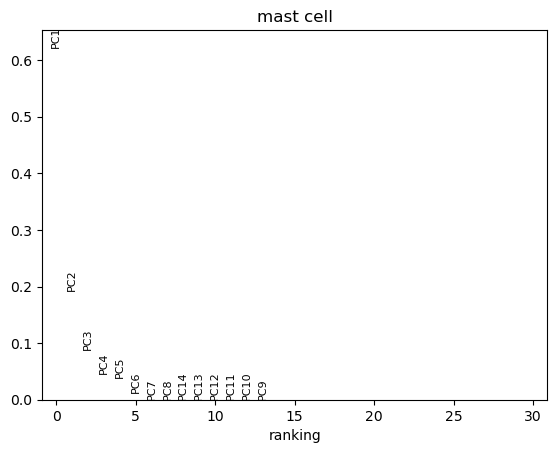

In [47]:
for i in adatas[1.0].keys():
    sc.pp.pca(adatas[1.0][i], n_comps=14)
    sc.pl.pca_variance_ratio(adatas[1.0][i],show=False)
    plt.title(i)

C: Multipe PC dimensions are important for explaining the data - can not just select top 2.

In [20]:
# BW of every PC dim
for i in range(adatas[1.0]['retinal rod cell'].obsm['X_pca'].shape[1]):
    print(FFTKDE(kernel='cosine', bw='ISJ').fit(adatas[1.0]['retinal rod cell'].obsm['X_pca'][:,i]).bw)

0.02203483732335962
0.043103031928365086
0.025950927598622234
0.018331499548155085
0.012850048769642361
0.006529465390289722
4.3227127123200893e-05
3.916565800423873e-05
2.932619475413331e-05
2.8432856905508717e-05
2.427073648428125e-05
2.407133765242399e-05
1.1539854912975694e-05


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/KDEpy/bw_selection.py:84: RuntimeWarning: divide by zero encountered in power
  t_opt = np.power(2 * N * np.sqrt(np.pi) * f, -2.0 / 5)
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/KDEpy/bw_selection.py:78: RuntimeWarning: divide by zero encountered in longdouble_scalars
  time = np.power((2 * const * K0 / (N * f)), (2.0 / (3.0 + 2.0 * s)))


ValueError: Root finding did not converge. Need more data.

C: The most important PCs have higher bw, but in generally differ accross dimensions

Check how 2PC KDE looks like, set constant BW

In [40]:
grid, density = FFTKDE(kernel='cosine', bw=0.03).fit(
    adatas[1.0]['retinal rod cell'].obsm['X_pca'][:,:2]).evaluate()

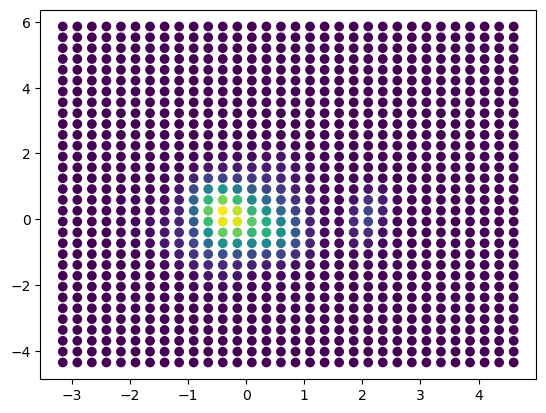

In [41]:
plt.scatter(grid[:,0],grid[:,1],c=density)

C: 2D PC KDE looses much info (see below UMAP for comparison)

Try to work with UMAP - compresses data to 2D and may have more similar size range accross dims

In [23]:
sc.tl.umap(adatas[1.0]['retinal rod cell'])

In [24]:
# BW per UMAP dim
for i in range(adatas[1.0]['retinal rod cell'].obsm['X_umap'].shape[1]):
    print(FFTKDE(kernel='cosine', bw='ISJ').fit(adatas[1.0]['retinal rod cell'].obsm['X_umap'][:,i]).bw)

0.10869012701806456
0.11039516090386738


C: UMAP rep has similar bw for both components

In [26]:
# UMAP KDE
grid, density = FFTKDE(kernel='cosine', bw=0.1).fit(
    adatas[1.0]['retinal rod cell'].obsm['X_umap']).evaluate()

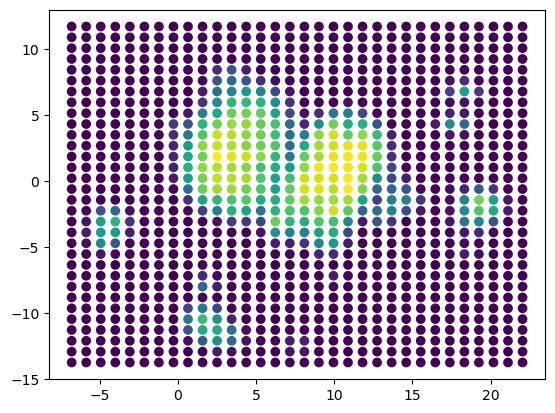

In [37]:
plt.scatter(grid[:,0],grid[:,1],c=density)

C: UMAP KDE seems to nicely capture substructures

(array([302.,  20.,  18.,   6.,   8.,   4.,   7.,   4.,   1.,   4.]),
 array([1.18379653e-06, 4.55490183e-01, 9.10979183e-01, 1.36646818e+00,
        1.82195718e+00, 2.27744618e+00, 2.73293518e+00, 3.18842418e+00,
        3.64391318e+00, 4.09940218e+00, 4.55489118e+00]),
 <BarContainer object of 10 artists>)

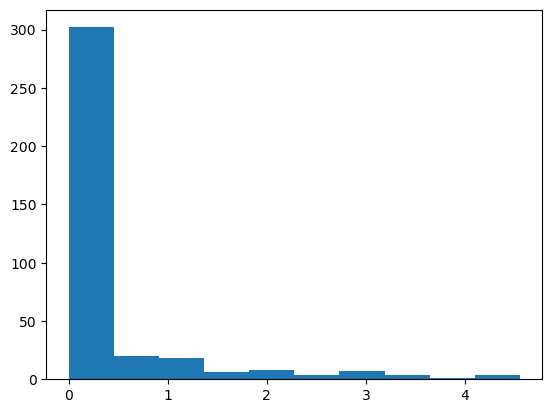

In [45]:
plt.hist(density[density!=density.min()])

If we just use histogram of KDE (and its variance) for representing KDE it may loose info on subclusters - e.g. are communities separated or single blob with different density. Unclear if surface/circumfence ration could be enough to dinstinguish.

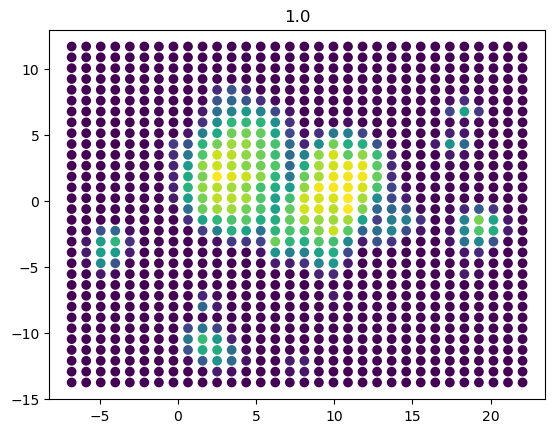

1.0 mean 0.034206112260568064 std 0.0323970548063855


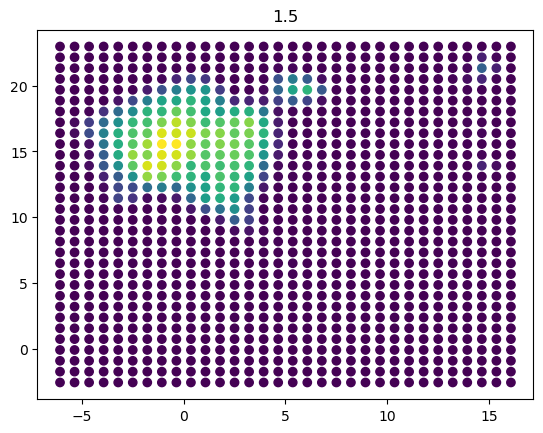

1.5 mean 0.04034838628878149 std 0.05190574441687165


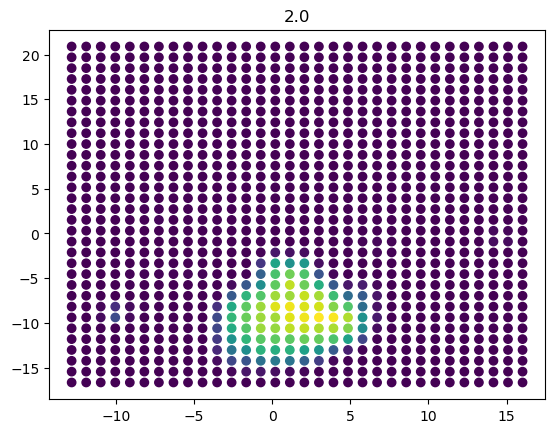

2.0 mean 0.04844806234675246 std 0.0755529155716696


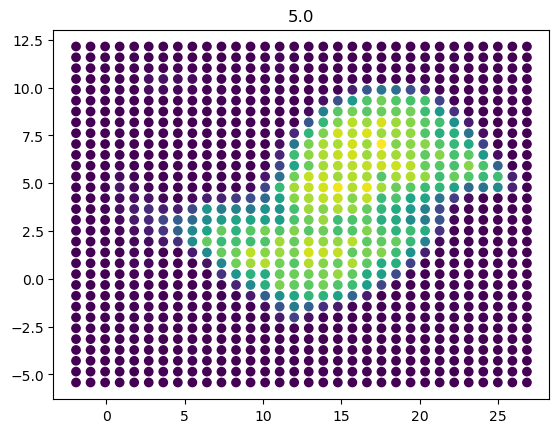

5.0 mean 0.02638163718881874 std 0.024855764671795268


In [52]:
for kl in adatas.keys():
    grid, density = FFTKDE(kernel='cosine', bw=0.1).fit(
        adatas[kl]['retinal rod cell'].obsm['X_umap']).evaluate()
    plt.scatter(grid[:,0],grid[:,1],c=density)
    plt.title(kl)
    plt.show()
    plt.close()
    density_filtered=density[density!=density.min()]
    print(kl, 'mean',density_filtered.mean(),'std',density_filtered.std())

C: Summaries of KDE can not distinguish between less/more structured data. Although it is possible that Kl=5 may be more structured than kl 1.5/2?

## N clusters

In [150]:
for res in [0.3, 0.7]:
    for kl in adatas.keys():
        sc.tl.leiden(adatas[kl]['retinal rod cell'],resolution=res,neighbors_key='knn30')
        n_cl=adatas[kl]['retinal rod cell'].obs['leiden'].nunique()
        print('res',res,'kl',kl,'N cl',n_cl)

res 0.3 kl 1.0 N cl 14
res 0.3 kl 1.5 N cl 9
res 0.3 kl 2.0 N cl 9
res 0.3 kl 5.0 N cl 10
res 0.7 kl 1.0 N cl 18
res 0.7 kl 1.5 N cl 15
res 0.7 kl 2.0 N cl 15
res 0.7 kl 5.0 N cl 22


C: Leiden clusters are not necesarily good representatives of how structured the embedding is. Also the patterns are different accross resolutions.